# Data Preparation

In [1]:
pip install yfinance # install yahoo finance library

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'

[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# import the libraries
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import yfinance as yf

In [3]:
# Function to retrieve the daily adjusted closing prices for the specified tokens within the past given years.

def stock_data(tokens, years):
    data = pd.DataFrame()
    stocks = list()
    # Calculate the end date (today's date)
    end_date = datetime.today()
    for i in tokens:
        # Calculate the start date by subtracting years from the end date
        start_date = end_date - timedelta(days=years * 365)
        # Download historical data for the specified ticker and within the date range
        historical_data = yf.download(i, start=start_date, end=end_date)
        # Concatenate the adjusted closing prices to the dataframe
        data = pd.concat([data, pd.DataFrame(historical_data['Adj Close'])], axis=1)
        stocks.append(i)
    # Rename columns with ticker names
    data.columns = stocks
    return data

tokens = ["BTC-USD","AVAX-USD"] 
years = 2

stock_df = stock_data(tokens,years) 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


stock_df is the dataframe contains the daily prices for BTC and AVAX for last 2 years.

In [4]:
#Display the last few rows of data
column_names=['BTC','AVAX'] # rename the columns
stock_df.columns=column_names
stock_df.tail(3)

,BTC,AVAX
Date,,
2024-06-03,68804.781250,35.040466
2024-06-04,70567.765625,36.073288
2024-06-05,70800.906250,36.388355


# # Data cleaning

In [5]:
#check the data types of each variables
stock_df.dtypes

BTC     float64
AVAX    float64
dtype: object

In [6]:
#check for the missing values.
stock_df[['BTC','AVAX']].isnull().values.any()

False

No missing values found here.

In [7]:
#check for any impossible values
stock_df['BTC'][stock_df.BTC<=0]

Series([], Name: BTC, dtype: float64)

In [8]:
stock_df['AVAX'][stock_df.AVAX<=0]

Series([], Name: AVAX, dtype: float64)

<Figure size 576x432 with 0 Axes>

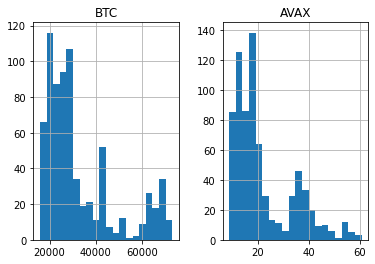

In [9]:
#check for the outliers
plt.figure(figsize=(8,6))
stock_df.hist(bins=20)
plt.show()

# # Statistical Analysis

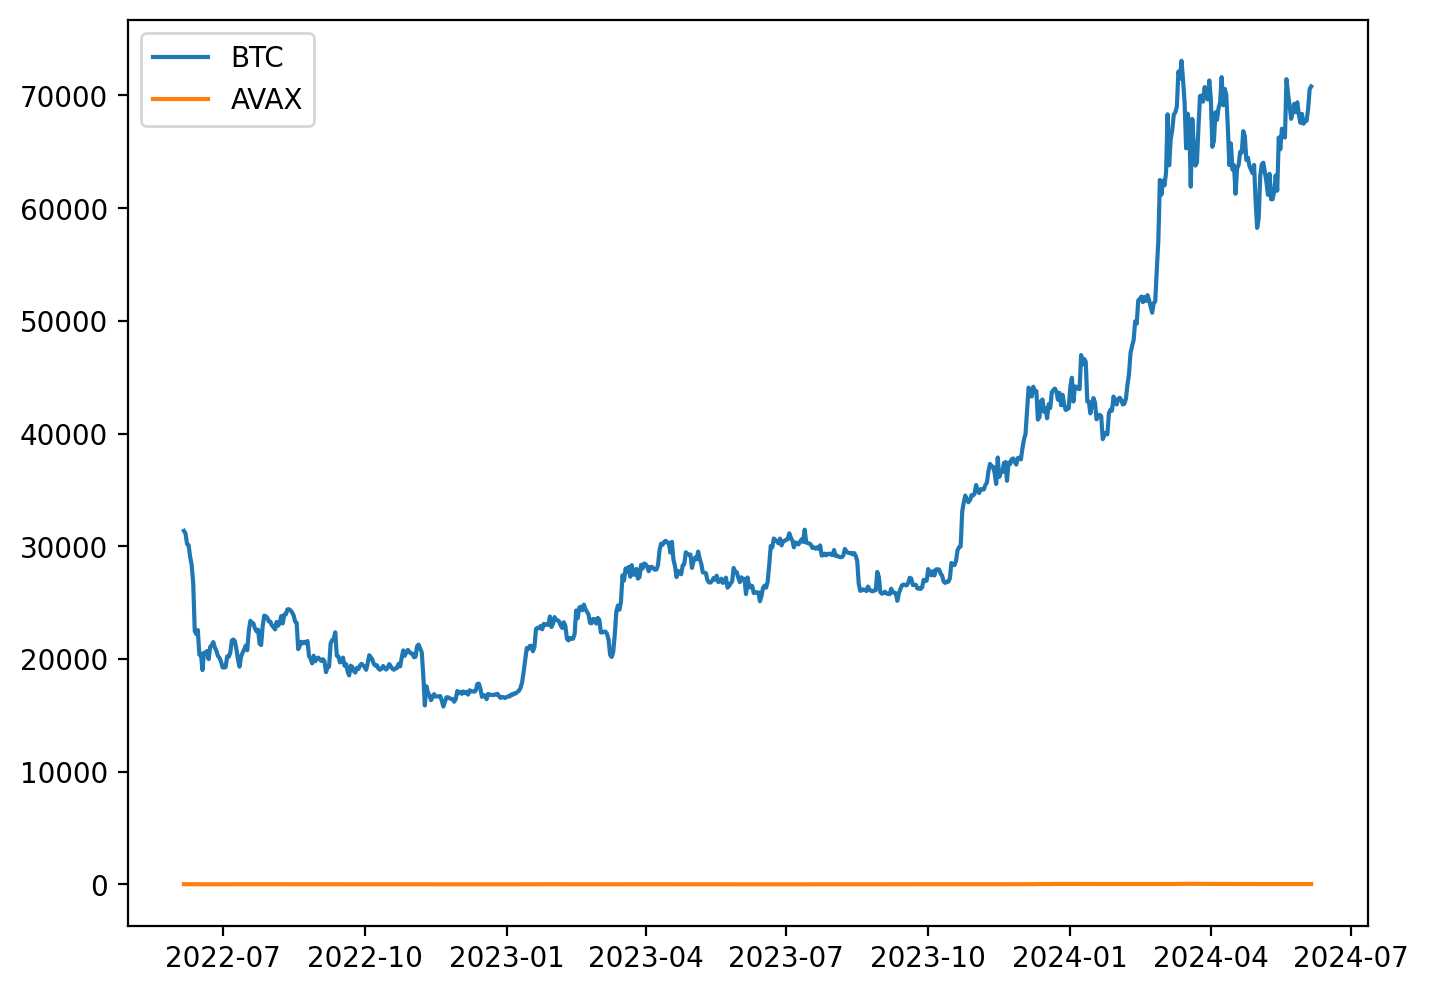

In [10]:
# Visualize the price trend in line chart.

plt.figure(figsize=(8, 6), dpi=200)  # Define the figure size and dpi
BTC = stock_df['BTC'] 
AVAX = stock_df['AVAX'] 
plt.plot(BTC, label="BTC")
plt.plot(AVAX, label="AVAX")
plt.legend()
plt.show()  # Show the plot

In this case, as the price ranges differ, the trends will be displayed using dual-axis line chart.

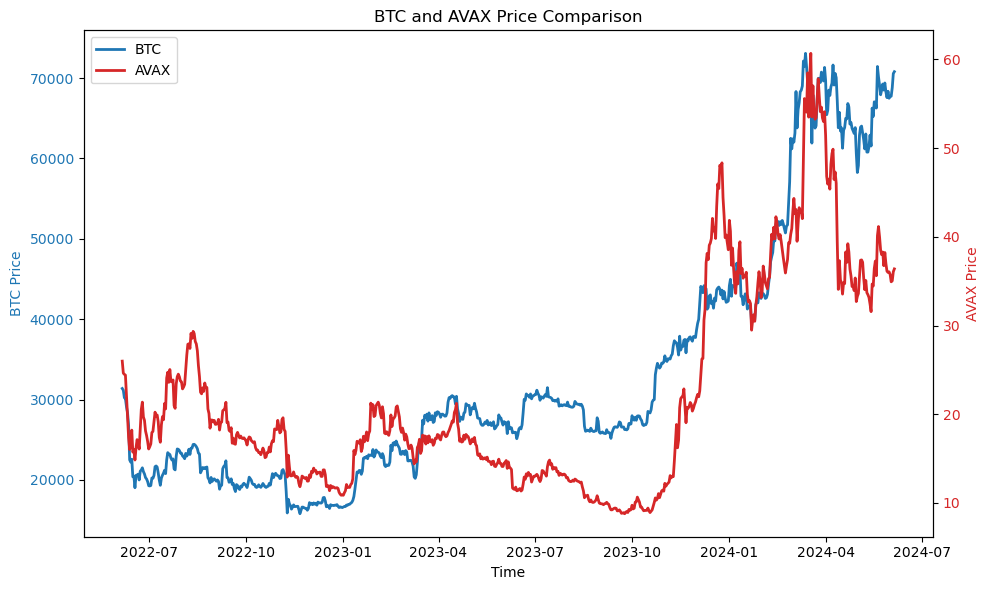

In [11]:
# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=100)

# Plot the first time series for BTC on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('BTC Price', color=color)
ax1.plot(BTC, color=color, linestyle='-', linewidth=2, label='BTC')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for the AVAX second time series
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('AVAX Price', color=color)
ax2.plot(AVAX, color=color, linewidth=2, label='AVAX')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and legend
plt.title('BTC and AVAX Price Comparison')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust layout and display the plot
fig.tight_layout()
plt.show()

Here we can see some strong correlation between BTC and AVAX

In [12]:
#Calculate the pairwise correlation coefficients.
cc = stock_df.corr()
cc

,BTC,AVAX
BTC,1.000000,0.835621
AVAX,0.835621,1.000000


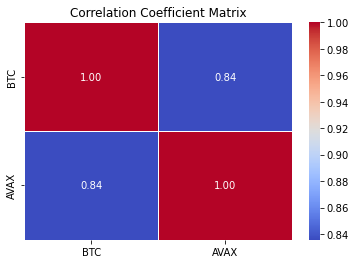

In [13]:
# Visualize the correlation in the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cc, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Coefficient Matrix')
plt.show()

# # Augmented Dickey-Fuller (ADF) Test

Before performing mean reversion we need to check for the stationarity. Here ADF test is used for this purpose.

In [14]:
from statsmodels.tsa.stattools import adfuller

columns_to_test = ['BTC', 'AVAX']  # List of columns to test

# Iterate over each column and perform ADF test
for column in columns_to_test:
    data = stock_df[column]
    result = adfuller(data)
    
    # Extracting results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    # Printing results
    print(f"Results for {column}:")
    print("-----------------------------------------------")    
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)
    print("Critical Values:", critical_values)
    print("-----------------------------------------------")

Results for BTC:
-----------------------------------------------
ADF Statistic: 0.9054545497098012
p-value: 0.9931610983976155
Critical Values: {'1%': -3.439593802573824, '5%': -2.865619356068967, '10%': -2.568942332870462}
-----------------------------------------------
Results for AVAX:
-----------------------------------------------
ADF Statistic: -1.719695661865668
p-value: 0.4209943129544415
Critical Values: {'1%': -3.439516060164992, '5%': -2.8655850998755263, '10%': -2.5689240826597173}
-----------------------------------------------


Based on the p-values:

For Bitcoin, the p-value is approximately 0.993, which is much greater than 0.05. Therefore, we fail to reject the null hypothesis, indicating that the BTC series is likely non-stationary.

For Avalanche, the p-value is approximately 0.414, which is also greater than 0.05. Similarly, we fail to reject the null hypothesis, suggesting that the AVAX series is likely non-stationary as well.

In conclusion neither the BTC nor AVAX series appears to be stationary. Therefore further ananlysis required.

## Phillips–Perron (PP) test 

In [15]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from arch.unitroot import PhillipsPerron  

columns_to_test = ['BTC', 'AVAX']  # List of columns to test

# Iterate over each column and perform PP test
for column in columns_to_test:
    data = stock_df[column]
    pp_test = PhillipsPerron(data)  # Using PhillipsPerron class
    
    # Extracting results
    pp_statistic = pp_test.stat  # PP statistic
    p_value = pp_test.pvalue  # p-value
    critical_values = pp_test.critical_values  # Critical values
    
    # Printing results
    print(f"Results for {column}:")
    print("-----------------------------------------------")
    print("PP Statistic:", pp_statistic)
    print("p-value:", p_value)
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"\t{key}: {value}")
    print("-----------------------------------------------")

Results for BTC:
-----------------------------------------------
PP Statistic: 0.861788188817835
p-value: 0.9925708295752987
Critical Values:
	1%: -3.4393396487377155
	5%: -2.865507363200066
	10%: -2.5688826684180897
-----------------------------------------------
Results for AVAX:
-----------------------------------------------
PP Statistic: -1.4617214197622523
p-value: 0.5523551406570572
Critical Values:
	1%: -3.4393396487377155
	5%: -2.865507363200066
	10%: -2.5688826684180897
-----------------------------------------------


In conclusion neither the BTC nor AVAX series appears to be stationary.

# # Mean reversion

We calculate the mean and standard deviation as they are essential parameters for implementing a mean reversion trading strategy.

In [17]:
mean_BTC = stock_df['BTC'].mean()
std_BTC = stock_df['BTC'].std()

mean_AVAX = stock_df['AVAX'].mean()
std_AVAX = stock_df['AVAX'].std()

print("mean BTC:",mean_BTC)
print("std BTC:",std_BTC)
print("mean AVAX:",mean_AVAX)
print("std AVAX:",std_AVAX)

mean BTC: 32769.308676577464
std BTC: 15573.23688092766
mean AVAX: 21.910253592620307
std AVAX: 11.594843449357462


In [18]:
# Calculate the price spread
stock_df['Spread'] = stock_df['BTC'] - stock_df['AVAX']

# Calculate rolling mean and standard deviation
rolling_mean = stock_df['Spread'].rolling(window=30).mean()  # 30-day rolling mean
rolling_sd = stock_df['Spread'].rolling(window=30).std()  # 30-day rolling standard deviation

# show the last few rows of data
print(stock_df.tail(3))
print("----------------------------")

# Print the last few rows of rolling mean and standard deviation
print("Last 3 rows of Rolling Mean:")
print(rolling_mean.tail(3))
print("----------------------------")
print("Last 3 rows of Rolling Standard Deviation:")
print(rolling_sd.tail(3))

                     BTC       AVAX        Spread
Date                                             
2024-06-03  68804.781250  35.040466  68769.740784
2024-06-04  70567.765625  36.073288  70531.692337
2024-06-05  70800.906250  36.388355  70764.517895
----------------------------
Last 3 rows of Rolling Mean:
Date
2024-06-03    66075.886932
2024-06-04    66293.818981
2024-06-05    66548.475882
Name: Spread, dtype: float64
----------------------------
Last 3 rows of Rolling Standard Deviation:
Date
2024-06-03    3152.343364
2024-06-04    3228.508722
2024-06-05    3270.947456
Name: Spread, dtype: float64


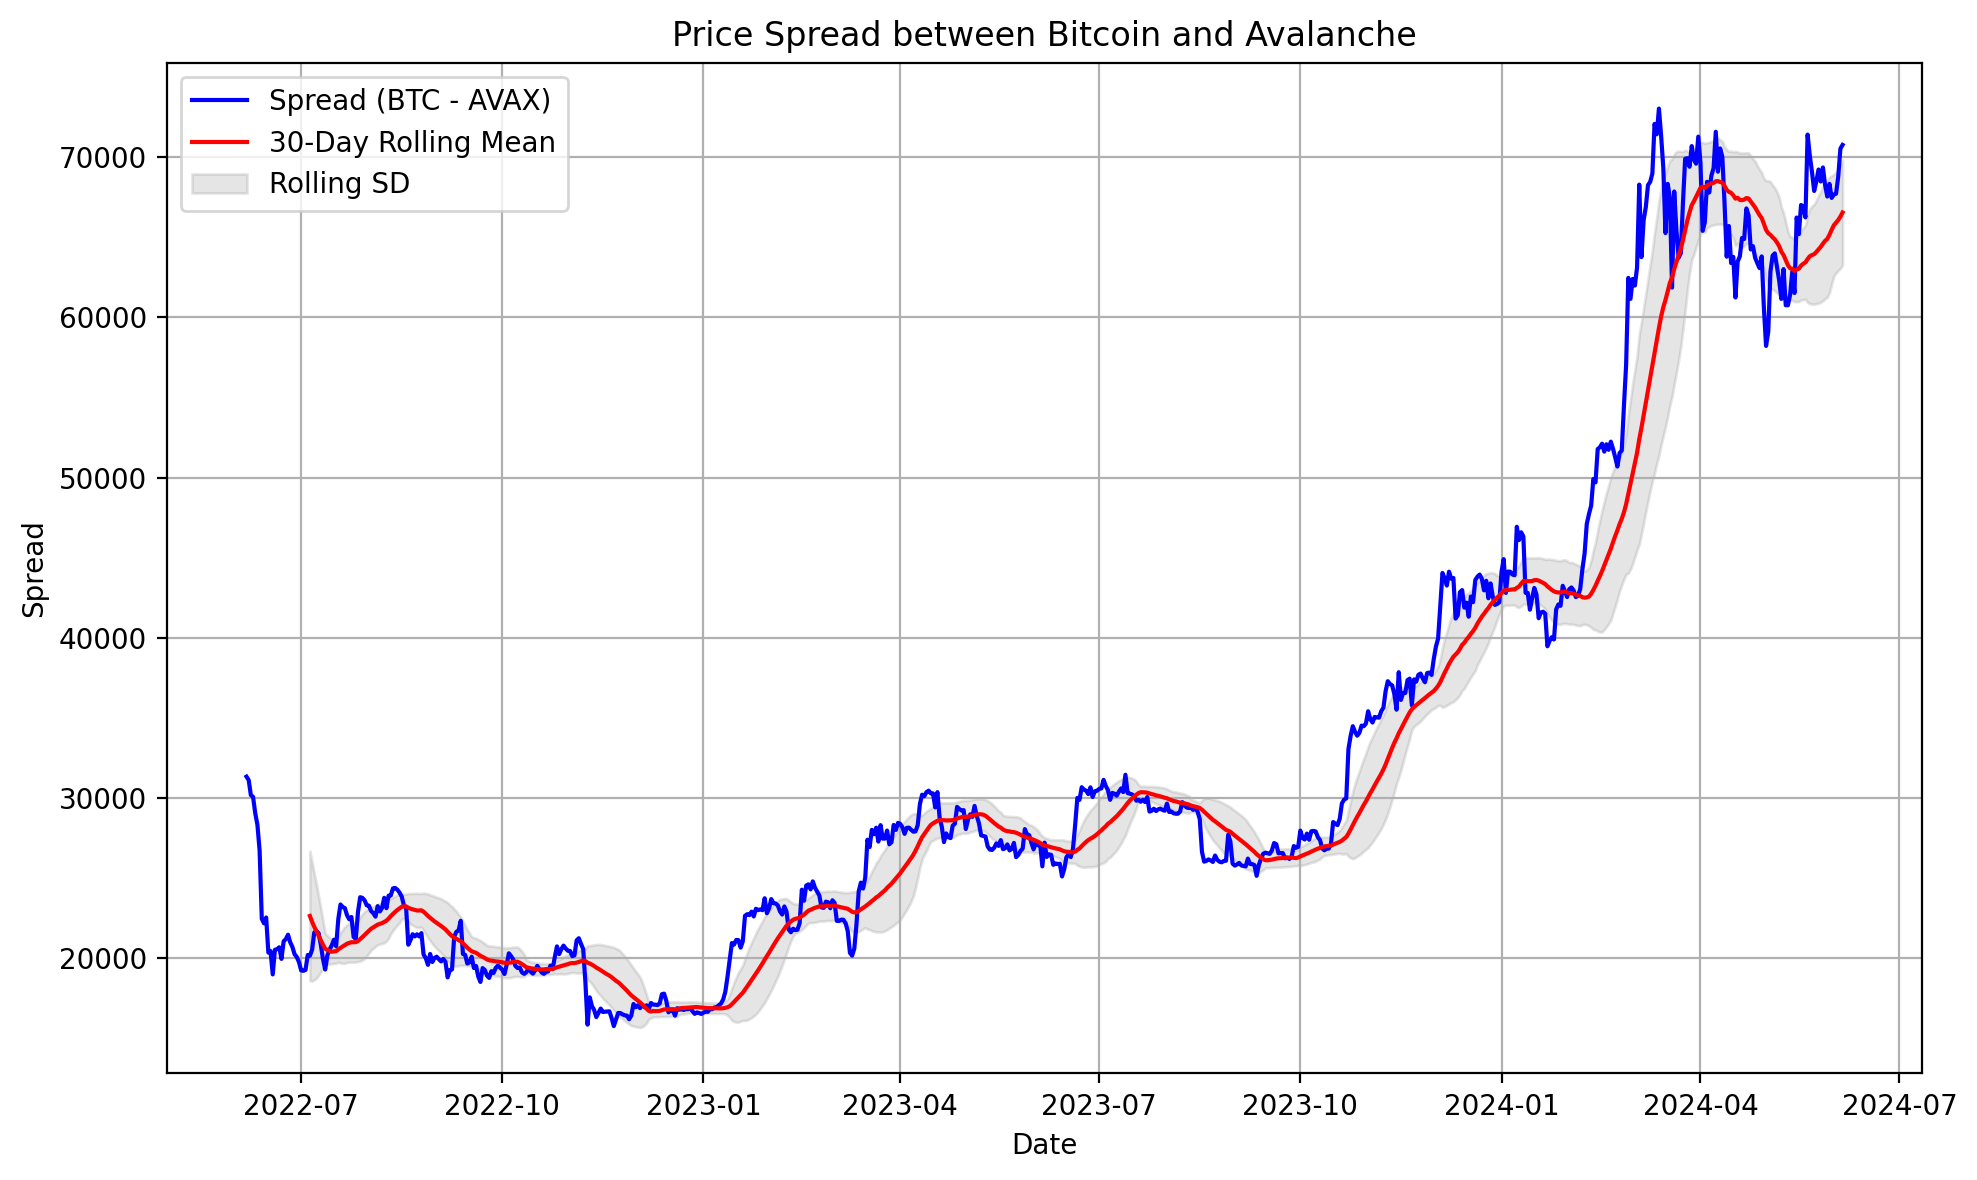

In [21]:
# Plotting the rolling mean and SD for the price spread between BTC and AVAX
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(stock_df.index, stock_df['Spread'], label='Spread (BTC - AVAX)', color='blue')
plt.plot(stock_df.index, rolling_mean, label='30-Day Rolling Mean', color='red')
plt.fill_between(stock_df.index, rolling_mean - rolling_sd, rolling_mean + rolling_sd, color='gray', alpha=0.2, label='Rolling SD')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Price Spread between Bitcoin and Avalanche')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Calculate Z-score of the spread
stock_df['Z_Score'] = (stock_df['Spread'] - stock_df['Spread'].rolling(window=30).mean()) / stock_df['Spread'].rolling(window=30).std()

# Define thresholds for potential buy and sell signals
buy_threshold = -2  # Buy signal when Z-score is below this threshold
sell_threshold = 2  # Sell signal when Z-score is above this threshold

# Identify potential mean reversion signals
potential_buy_signals = stock_df[stock_df['Z_Score'] < buy_threshold]
potential_sell_signals = stock_df[stock_df['Z_Score'] > sell_threshold]

# Print potential buy and sell signals
print("Potential Buy Signals:")
print(potential_buy_signals)
print("\nPotential Sell Signals:")
print(potential_sell_signals)


Potential Buy Signals:
                     BTC       AVAX        Spread   Z_Score
Date                                                       
2022-08-19  20877.552734  22.487879  20855.064856 -2.633864
2022-08-20  21166.060547  22.302879  21143.757668 -2.054674
2022-08-26  20260.019531  20.598030  20239.421501 -2.298436
2022-08-27  20041.738281  20.077759  20021.660522 -2.188038
2022-08-28  19616.814453  18.430382  19598.384071 -2.215645
2022-11-09  15880.780273  12.917875  15867.862398 -3.665287
2022-11-11  17034.292969  14.095546  17020.197423 -2.128719
2022-11-12  16799.185547  13.064071  16786.121476 -2.072310
2022-11-13  16353.365234  13.052020  16340.313214 -2.141267
2023-03-09  20363.021484  14.403960  20348.617524 -2.360510
2023-03-10  20187.244141  14.829691  20172.414450 -2.213058
2023-06-05  25760.097656  13.897244  25746.200412 -2.540400
2023-06-10  25851.240234  11.680258  25839.559977 -2.112977
2023-06-14  25124.675781  11.366084  25113.309697 -2.470608
2023-07-24  29176

Z-Score Calculation: Calculates the Z-score of the spread using the formula:

Z_Score =   Spread − 30 day Rolling Mean of Spread
                                                / 30 day Rolling Standard Deviation of Spread


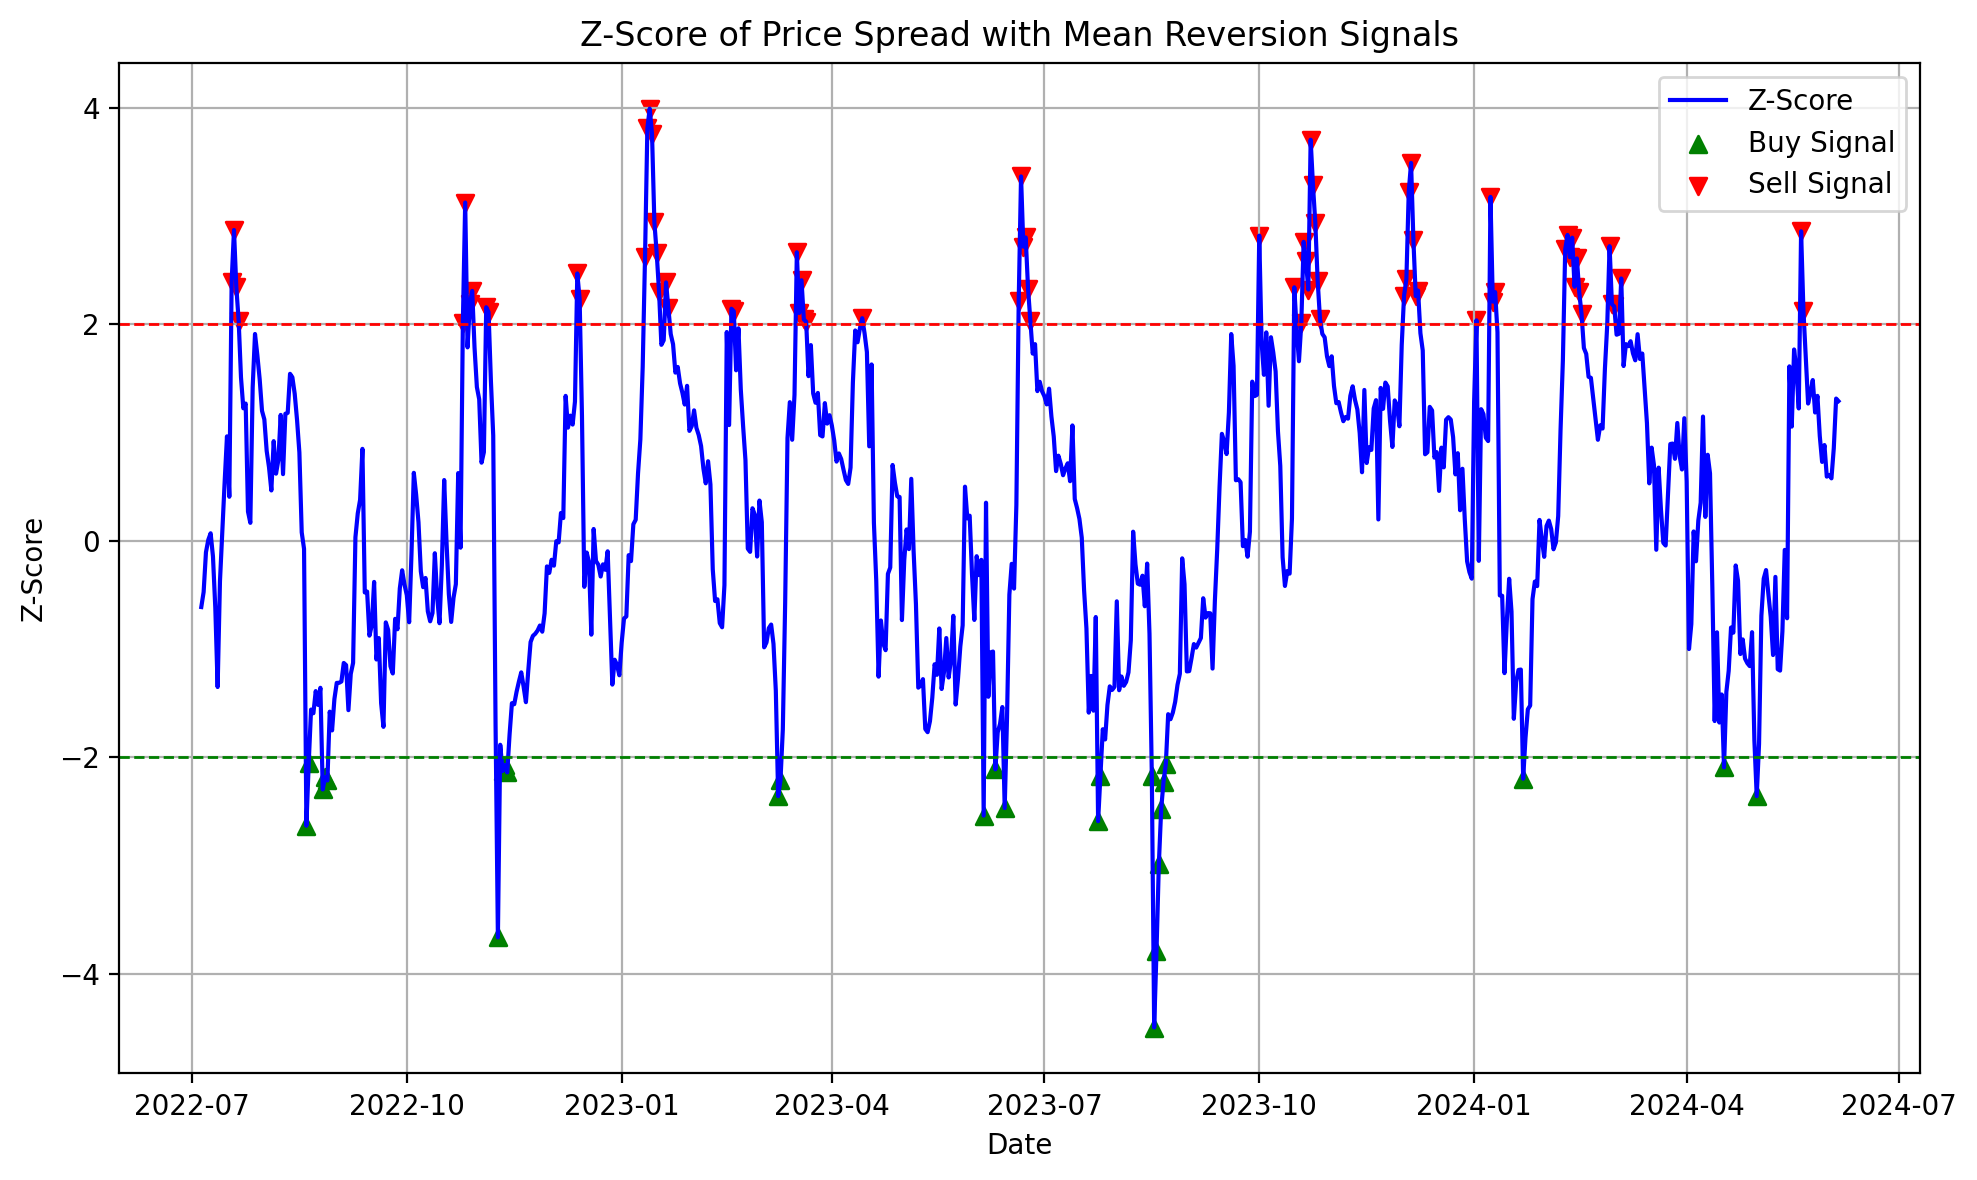

In [26]:
# Plotting
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(stock_df.index, stock_df['Z_Score'], label='Z-Score', color='blue')
plt.scatter(potential_buy_signals.index, potential_buy_signals['Z_Score'], color='green', marker='^', label='Buy Signal')
plt.scatter(potential_sell_signals.index, potential_sell_signals['Z_Score'], color='red', marker='v', label='Sell Signal')
plt.axhline(buy_threshold, color='green', linestyle='--', linewidth=1)
plt.axhline(sell_threshold, color='red', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title('Z-Score of Price Spread with Mean Reversion Signals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

When the Z-score is low, it indicates that the current spread is below its historical average, suggesting that it may be undervalued. Conversely, when the Z-score is high, it indicates that the current spread is above its historical average, suggesting that it may be overvalued.

However it's essential to thoroughly backtest and validate any trading strategy before implementing it in a live trading environment. Additionally, the effectiveness of such strategies may vary depending on the market conditions and the specific assets being traded.

# Trading strategies

The dataframe containing historical data is already clean. And speadis also calculated.

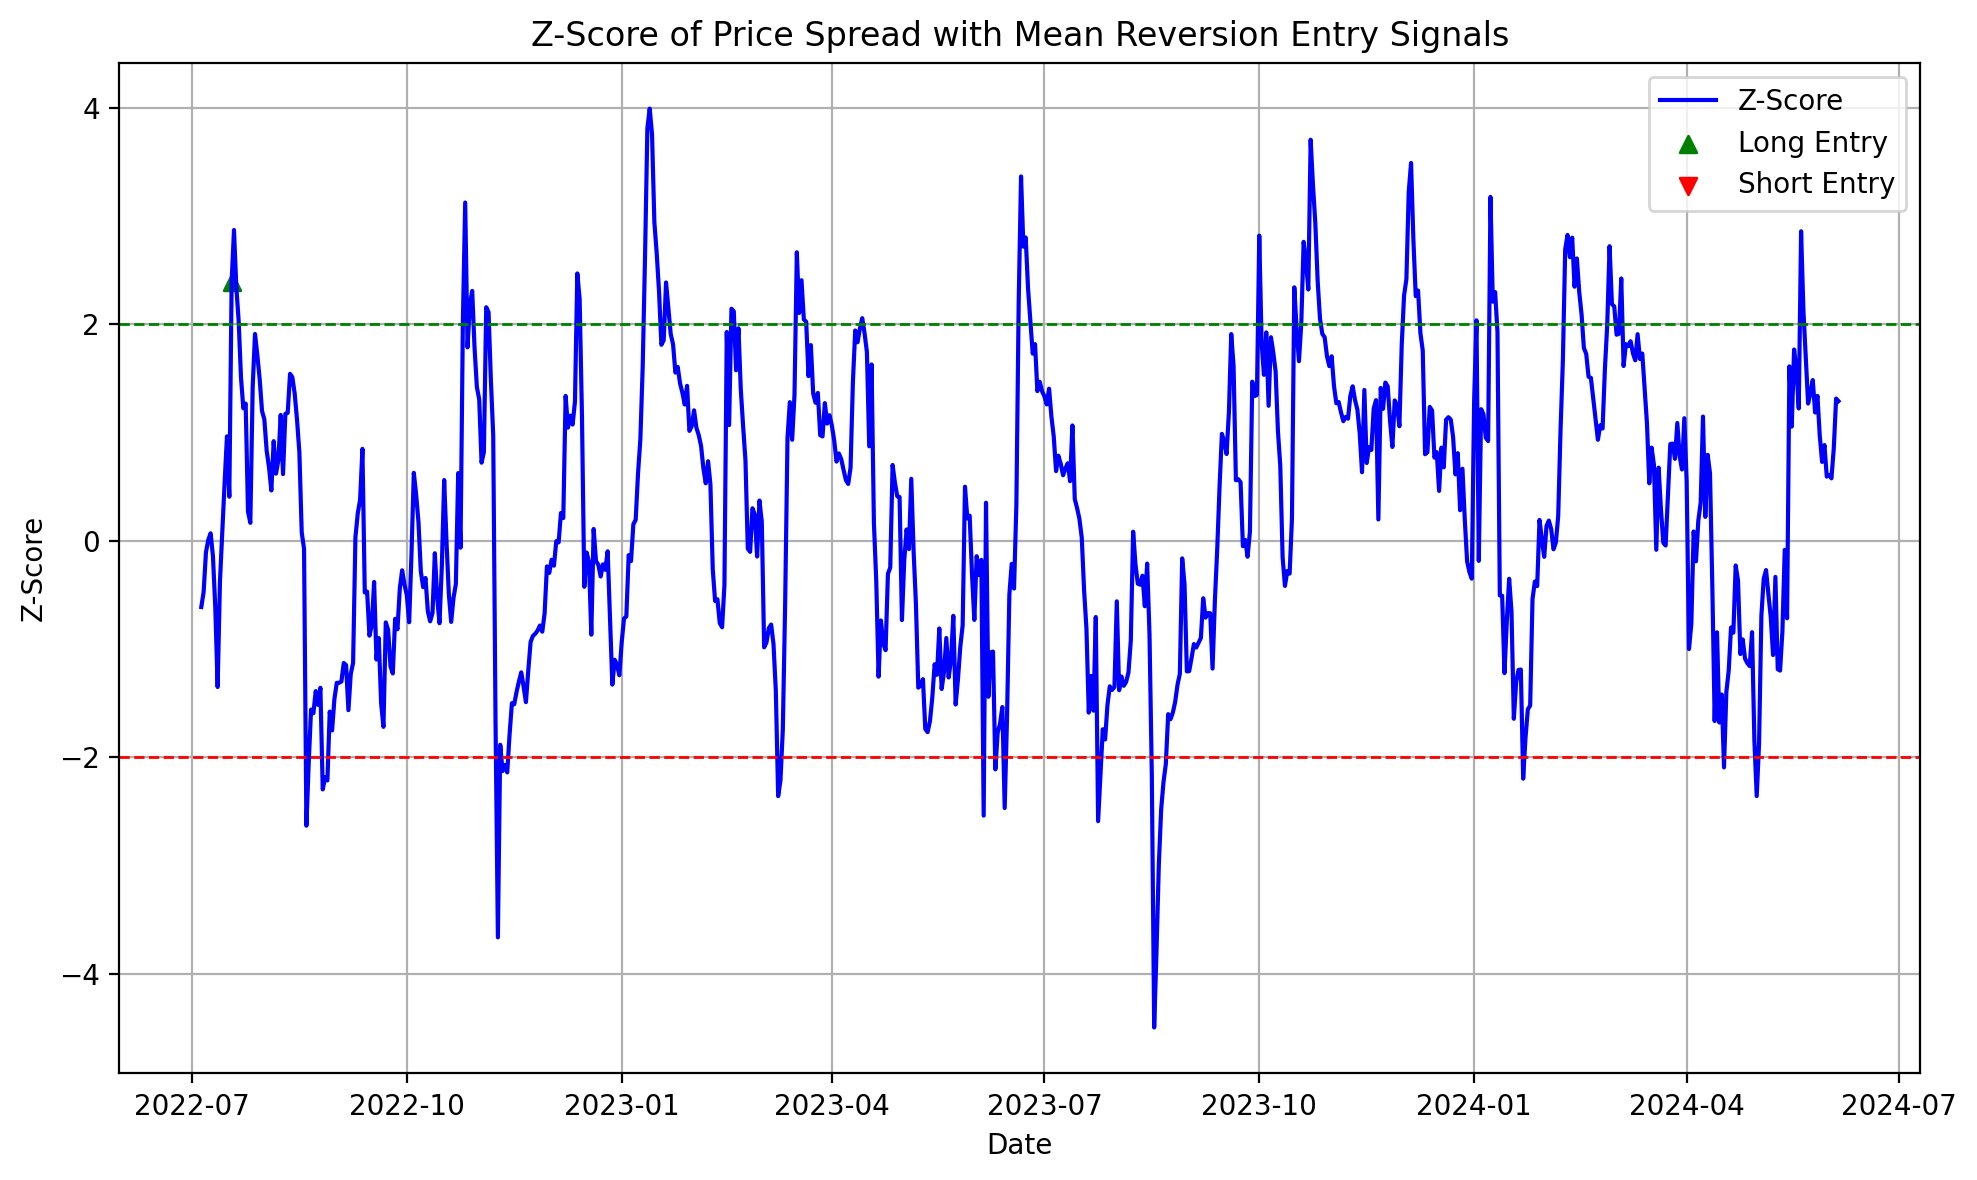

In [27]:
# Define entry and exit thresholds
entry_threshold = 2
exit_threshold = 0  # Revert to the mean

# Initialize variables to track positions
in_trade = False
entry_price = 0

# Create an extra column to track positions in the stock dataframe
stock_df['Position'] = None

# Loop through each row in the DataFrame
for index, row in stock_df.iterrows():
    # Check if Z-score crosses the entry threshold
    if row['Z_Score'] > entry_threshold and not in_trade:
        # Enter a long position
        in_trade = True
        entry_price = row['Spread']
        stock_df.at[index, 'Position'] = 1  # Long position

    # Check if Z-score crosses the negative entry threshold
    elif row['Z_Score'] < -entry_threshold and not in_trade:
        # Enter a short position
        in_trade = True
        entry_price = row['Spread']
        stock_df.at[index, 'Position'] = -1  # Short position

    # Check if Z-score reverts to the exit threshold
    elif abs(row['Z_Score']) < exit_threshold and in_trade:
        # Exit the trade
        in_trade = False
        exit_price = row['Spread']
        if entry_price < exit_price:
            # Profit
            stock_df.at[index, 'Position'] = 1 if row['Z_Score'] > 0 else 0  # Exit long position
        else:
            # Loss
            stock_df.at[index, 'Position'] = -1 if row['Z_Score'] < 0 else 0  # Exit short position

# Plotting
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(stock_df.index, stock_df['Z_Score'], label='Z-Score', color='blue')
plt.scatter(stock_df[stock_df['Position'] == 1].index, stock_df[stock_df['Position'] == 1]['Z_Score'], color='green', marker='^', label='Long Entry')
plt.scatter(stock_df[stock_df['Position'] == -1].index, stock_df[stock_df['Position'] == -1]['Z_Score'], color='red', marker='v', label='Short Entry')
plt.axhline(entry_threshold, color='green', linestyle='--', linewidth=1)
plt.axhline(-entry_threshold, color='red', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title('Z-Score of Price Spread with Mean Reversion Entry Signals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


simple moving average crossover strategy. In this strategy, we'll use two moving averages: a short-term moving average (e.g., 20-day) and a long-term moving average (e.g., 50-day). When the short-term moving average crosses above the long-term moving average, it generates a buy signal, and when it crosses below the long-term moving average, it generates a sell signal.

In [ ]:
import matplotlib.pyplot as plt

# Define short-term and long-term moving average windows
short_window = 20
long_window = 50

# Calculate short-term and long-term moving averages
stock_df['Short_MA'] = stock_df['Spread'].rolling(window=short_window, min_periods=1).mean()
stock_df['Long_MA'] = stock_df['Spread'].rolling(window=long_window, min_periods=1).mean()

# Initialize position column
stock_df['Position_MA'] = None

# Generate signals
stock_df['Position_MA'] = 0
stock_df.loc[stock_df['Short_MA'] > stock_df['Long_MA'], 'Position_MA'] = 1  # Buy signal
stock_df.loc[stock_df['Short_MA'] < stock_df['Long_MA'], 'Position_MA'] = -1  # Sell signal

# Plotting
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(stock_df.index, stock_df['Spread'], label='Spread', color='blue')
plt.plot(stock_df.index, stock_df['Short_MA'], label=f'{short_window}-day MA', color='orange')
plt.plot(stock_df.index, stock_df['Long_MA'], label=f'{long_window}-day MA', color='green')
plt.plot(stock_df[stock_df['Position_MA'] == 1].index, stock_df[stock_df['Position_MA'] == 1]['Spread'], '^', markersize=8, color='g', lw=0, label='Buy Signal')
plt.plot(stock_df[stock_df['Position_MA'] == -1].index, stock_df[stock_df['Position_MA'] == -1]['Spread'], 'v', markersize=8, color='r', lw=0, label='Sell Signal')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Moving Average Crossover Trading Strategy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Define the date range for the last 2 months
end_date = stock_df.index[-1]
start_date = end_date - timedelta(days=60)

# Slice the DataFrame to include only the data for the last month
stock_df_last_month = stock_df.loc[start_date:end_date].copy()

# Define short-term and long-term moving average windows
short_window = 20
long_window = 50

# Calculate short-term and long-term moving averages
stock_df_last_month['Short_MA'] = stock_df_last_month['Spread'].rolling(window=short_window, min_periods=1).mean()
stock_df_last_month['Long_MA'] = stock_df_last_month['Spread'].rolling(window=long_window, min_periods=1).mean()

# Initialize position column
stock_df_last_month['Position_MA'] = 0

# Generate signals
stock_df_last_month.loc[stock_df_last_month['Short_MA'] > stock_df_last_month['Long_MA'], 'Position_MA'] = 1  # Buy signal
stock_df_last_month.loc[stock_df_last_month['Short_MA'] < stock_df_last_month['Long_MA'], 'Position_MA'] = -1  # Sell signal

# Plotting
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(stock_df_last_month.index, stock_df_last_month['Spread'], label='Spread', color='blue')
plt.plot(stock_df_last_month.index, stock_df_last_month['Short_MA'], label=f'{short_window}-day MA', color='orange')
plt.plot(stock_df_last_month.index, stock_df_last_month['Long_MA'], label=f'{long_window}-day MA', color='green')
plt.plot(stock_df_last_month[stock_df_last_month['Position_MA'] == 1].index, stock_df_last_month.loc[stock_df_last_month['Position_MA'] == 1, 'Spread'], '^', markersize=8, color='g', lw=0, label='Buy Signal')
plt.plot(stock_df_last_month[stock_df_last_month['Position_MA'] == -1].index, stock_df_last_month.loc[stock_df_last_month['Position_MA'] == -1, 'Spread'], 'v', markersize=8, color='r', lw=0, label='Sell Signal')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Moving Average ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define features (X) and target variable (y)
X = stock_df[['BTC', 'AVAX']]  # Features
y = stock_df['BTC'] < stock_df['AVAX']  # Target variable: True if BTC < AVAX, False otherwise

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters from grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best parameters to train the decision tree classifier
best_clf = DecisionTreeClassifier(**best_params, random_state=42)
best_clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = best_clf.predict(X_test)

# Evaluate the model using various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Evaluation:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)